In [1]:
# import libraries to work with
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch,Patch
%matplotlib inline

In [2]:
# load the data

# 2019 survey
s2019 = pd.read_csv('kaggle-survey-2019/multiple_choice_responses.csv')
# list of survey questions
questions_2019 = s2019.iloc[0]
s2019.drop(0, inplace=True)

# 2021 survey
s2021 = pd.read_csv('kaggle-survey-2021/kaggle_survey_2021_responses.csv')
# list of survey questions
questions_2021 = s2021.iloc[0]
s2021.drop(0, inplace=True)

In [3]:
# have a look at dataframes

In [4]:
s2019.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,...,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT
1,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
2,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
3,83,55-59,Female,-1,Germany,Professional degree,NaN,-1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
4,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,...,NaN,NaN,NaN,NaN,NaN,Azure SQL Database,NaN,NaN,NaN,-1
5,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


In [5]:
s2021.head()

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,...,Q38_B_Part_3,Q38_B_Part_4,Q38_B_Part_5,Q38_B_Part_6,Q38_B_Part_7,Q38_B_Part_8,Q38_B_Part_9,Q38_B_Part_10,Q38_B_Part_11,Q38_B_OTHER
1,910,50-54,Man,India,Bachelor’s degree,Other,5-10 years,Python,R,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,784,50-54,Man,Indonesia,Master’s degree,Program/Project Manager,20+ years,NaN,NaN,SQL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
3,924,22-24,Man,Pakistan,Master’s degree,Software Engineer,1-3 years,Python,NaN,NaN,...,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,575,45-49,Man,Mexico,Doctoral degree,Research Scientist,20+ years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
5,781,45-49,Man,India,Doctoral degree,Other,< 1 years,Python,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
len(questions_2019),len(questions_2021)

(246, 369)

In [6]:
# functions and variables to process the data

The analysis is focused on Kaggle users that are new to both coding and machine learning with less than 3 years experience in both aspects.

In [7]:
# newbies will be those having no or under 3 years of experience in both programming and ML
# Q6 and Q15 in 2021 survey
# Q15  and Q23 in 2019 survey
prog_new = ['1-3 years','< 1 years','I have never written code','1-2 years']
ml_new = ['Under 1 year','1-2 years','I do not use machine learning methods','2-3 years',
         '< 1 years']

# function to extract data
def newbies(df,year):
    """
    Creates a dataframe where user have les than 3 or no
    experience in coding and using ml methods
    df - dataframe to work with (kaggle survey of certain year)
    year - int, 2019 or 2021, the year of a survey
    
    Returns required dataframe
    """
    
    prog_new = ['1-3 years','< 1 years','I have never written code','1-2 years']
    ml_new = ['Under 1 year','1-2 years','I do not use machine learning methods','2-3 years',
             '< 1 years']
    
    if year==2021:
        newbies = df[(df['Q6'].isin(prog_new))&(df['Q15'].isin(ml_new))]
        
    elif year==2019:
        newbies = df[(df['Q15'].isin(prog_new))&(df['Q23'].isin(ml_new))]
        
    return newbies

In [8]:
# a function to get all answers for multiple-answer questions
def get_questions(key_word,questions):
    """
    Gets all questions from list of questions that contain key word
    
    Returns list of strings containing key word
    """
    
    return questions[questions.index.str.contains(key_word)].index.to_list()

In [134]:
# put all the processing in one function
# puts answers of two surveys into similar format
def process(s2019,s2021):
    """
    Processes two dataframes, 2019 and 2021 surveys,
    so that the data is easier to interpret. Mostly maps different columns
    so that values have the same names on the graphs
    s2019 and s2021 - dataframes, 2019 survey and 2021 survey respectively
    
    Returns processesed s2019 and s2021, ready to visualize
    """
    
    # column with number of employees in a company
    s2021['Q21'] = ['> 10,000 employees' if val=='10,000 or more employees' else val \
               for val in s2021['Q21']]
    
    # salary columns
    salaries = {'$0-999':'$0-999',
                '10,000-14,999':'$10,000-14,999',   
                '100,000-124,999':'$100,000-124,999',     
                '30,000-39,999':'$30,000-39,999',    
                '40,000-49,999':'$40,000-49,999',      
                '50,000-59,999':'$50,000-59,999',      
                '1,000-1,999':'$1,000-1,999',
                '60,000-69,999':'$60,000-69,999',       
                '5,000-7,499':'$5,000-7,499',      
                '15,000-19,999':'$15,000-19,999',       
                '20,000-24,999':'$20,000-24,999',      
                '70,000-79,999':'$70,000-79,999',      
                '125,000-149,999':'$125,000-149,999',     
                '25,000-29,999':'$25,000-29,999',    
                '150,000-199,999':'$150,000-199,999',     
                '7,500-9,999':'$7,500-9,999',    
                '80,000-89,999':'$80,000-89,999',       
                '2,000-2,999':'$2,000-2,999',      
                '90,000-99,999':'$90,000-99,999',      
                '3,000-3,999':'$3,000-3,999',      
                '4,000-4,999':'$4,000-4,999',        
                '200,000-249999':'$200,000-249999',     
                '> $500,000':'> $500,000',           
                '300,000-500,000':'$300,000-500,000',      
                '250,000-299,999':'$250,000-299,999'}
    s2019['Q10'] = s2019['Q10'].map(salaries)
    s2021['Q25'] = s2021['Q25'].map(salaries)
    
    # ide columns
    ides = {
        'Jupyter (JupyterLab, Jupyter Notebooks, etc)':'Jupyter, etc',
        'RStudio':'RStudio',
        'PyCharm':'PyCharm',
        'Atom':'Atom',
        'MATLAB':'MATLAB',
        'Visual Studio / Visual Studio Code':'VSCode',
        'Spyder':'Spyder',
        'Vim / Emacs':'Vim / Emacs',
        'Notepad++':'Notepad++',
        'Sublime Text':'Sublime',
        'None':'None',
        'Other':'Other',
        'Visual Studio':'VSCode',
        'Visual Studio Code (VSCode)':'VSCode',
        'Jupyter Notebook':'Jupyter, etc'
        }
    
    for col in get_questions('Q16',questions_2019):
        try:
            s2019[col] = [value.strip() if value==value else value for value in s2019[col]]
        except:
            continue
    
    for col in get_questions('Q9',questions_2021):
        try:
            s2021[col] = [value.strip() if value==value else value for value in s2021[col]]
        except:
            continue
            
    for col in get_questions('Q16',questions_2019):
        try:
            s2019[col] = s2019[col].map(ides)
        except:
            continue

    for col in get_questions('Q9',questions_2021):
        try:
            s2021[col] = s2021[col].map(ides)
        except:
            continue
            
    # notebook columns
    notebooks = {
        ' Kaggle Notebooks (Kernels) ':'Kaggle notebooks',
        ' Kaggle Notebooks':'Kaggle notebooks',
        ' Google Colab ':'Colab notebooks',
        'Colab Notebooks':'Colab notebooks',
        ' Microsoft Azure Notebooks ':'Azure notebooks',
        'Azure Notebooks':'Azure notebooks',
        ' Google Cloud Notebook Products (AI Platform, Datalab, etc) ':'Google cloud products',
        ' Paperspace / Gradient ':'Paperspace/Gradient',
        ' Binder / JupyterHub ':'JupyterHub',
        ' FloydHub ':'FloydHub',
        ' Code Ocean ':'Code Ocean',
        'Code Ocean ':'Code Ocean',
        ' IBM Watson Studio ':'IBM Watson studio',
        ' Amazon Sagemaker Studio Notebooks ':'Amazon notebooks',
        ' Amazon EMR Notebooks ':'Amazon notebooks',
        'AWS Notebook Products (EMR Notebooks, Sagemaker Notebooks, etc) ':'Amazon notebooks',
        'Google Cloud Notebooks (AI Platform / Vertex AI) ':'Google cloud products',
        'Google Cloud Datalab':'Google cloud products',
        'None':'None',
        'Other':'Other',
        ' Databricks Collaborative Notebooks ':'Databricks',
        ' Zeppelin / Zepl Notebooks ':'Zeppelin notebooks',
        ' Deepnote Notebooks ':'Deepnote notebooks',
        ' Observable Notebooks ':'Observable notebooks'    
    }
    
    for col in get_questions('Q17',questions_2019):
        s2019[col] = s2019[col].map(notebooks)

    for col in get_questions('Q10',questions_2021):
        s2021[col] = s2021[col].map(notebooks)
        
    # courses columns
    courses = {
        'Udacity':'Udacity',
        'Coursera':'Coursera',
        'edX':'edX',
        'DataCamp':'DataCamp',
        'Kaggle Learn Courses':'Kaggle courses',
        'DataQuest':'DataQuest',
        'Fast.ai':'Fast.ai',
        'Kaggle Courses (i.e. Kaggle Learn)':'Kaggle courses',
        'Udemy':'Udemy',
        'LinkedIn Learning':'LinkedIn learning',
        'Cloud-certification programs (direct from AWS, Azure, GCP, or similar)':'Cloud certification',
        'University Courses (resulting in a university degree)':'University',
        'None':'None',
        'Other':'Other'
    }

    for col in get_questions('Q13',questions_2019):
        s2019[col] = s2019[col].map(courses)

    for col in get_questions('Q40',questions_2021):
        s2021[col] = s2021[col].map(courses)
        
    # media columns
    media = {
        'Twitter (data science influencers)':'Twitter',
        'Hacker News (https://news.ycombinator.com/)':'Hacker news',
        "Email newsletters (Data Elixir, O'Reilly Data & AI, etc)":'Email newsletters',
        'Reddit (r/machinelearning, r/datascience, etc)':'Reddit',
        'Reddit (r/machinelearning, etc)':'Reddit',
        'Kaggle (forums, blog, social media, etc)':'Kaggle',
        'Kaggle (notebooks, forums, etc)':'Kaggle',
        'Course Forums (forums.fast.ai, etc)':'Course forums',
        'Course Forums (forums.fast.ai, Coursera forums, etc)':'Course forums',
        'YouTube (Cloud AI Adventures, Siraj Raval, etc)':'YouTube',
        'YouTube (Kaggle YouTube, Cloud AI Adventures, etc)':'YouTube',
        'Podcasts (Chai Time Data Science, Linear Digressions, etc)':'Podcasts',
        'Podcasts (Chai Time Data Science, O’Reilly Data Show, etc)':'Podcasts',
        'Blogs (Towards Data Science, Medium, Analytics Vidhya, KDnuggets etc)':'Blogs',
        'Blogs (Towards Data Science, Analytics Vidhya, etc)':'Blogs',
        'Journal Publications (traditional publications, preprint journals, etc)':'Journal publications',
        'Journal Publications (peer-reviewed journals, conference proceedings, etc)':'Journal publications',
        'Slack Communities (ods.ai, kagglenoobs, etc)':'Slack communities',
        'None':'None',
        'Other':'Other'
    }

    for col in get_questions('Q12',questions_2019):
        s2019[col] = s2019[col].map(media)

    for col in get_questions('Q42',questions_2021):
        s2021[col] = s2021[col].map(media)
        
    # gender columns
    gender = {
        'Man':'Male',
        'Male':'Male',
        'Woman':'Female',
        'Female':'Female',
        'Prefer not to say':'Prefer not to say',
        'Nonbinary':'Nonbinary',
        'Prefer to self-describe':'Prefer to self-describe'
    }
    
    for df in [s2019,s2021]:
        df['Q2'] = df['Q2'].map(gender)
        
    # algos columns
    algos = {
        'Linear or Logistic Regression':'Regressions',
        'Decision Trees or Random Forests':'Tree based',
        'Gradient Boosting Machines (xgboost, lightgbm, etc)':'Boosting',
        'Bayesian Approaches':'Bayesian',
        'Evolutionary Approaches':'Evolutionary',
        'Dense Neural Networks (MLPs, etc)':'Dense NN',
        'Convolutional Neural Networks':'CNN',
        'Generative Adversarial Networks':'Generative Adversarial Networks',
        'Recurrent Neural Networks':'RNN',
        'Transformer Networks (BERT, gpt-2, etc)':'Transformer networks',
        'Transformer Networks (BERT, gpt-3, etc)':'Transformer networks',
        'None':'None',
        'Other':'Other'
    }
    
    for col in get_questions('Q24',questions_2019):
        s2019[col] = s2019[col].map(algos)

    for col in get_questions('Q17',questions_2021):
        s2021[col] = s2021[col].map(algos) 
        
    # work duties columns
    work_duties = {
        'Analyze and understand data to influence product or business decisions':'Data analysis',
        'Build and/or run the data infrastructure that my business uses for storing, analyzing, and operationalizing data':'Data infrastructure',
        'Build prototypes to explore applying machine learning to new areas':'Model building',
        'Build and/or run a machine learning service that operationally improves my product or workflows':'Model building',
        'Experimentation and iteration to improve existing ML models':'Model improvement',
        'Do research that advances the state of the art of machine learning':'RND',
        'None of these activities are an important part of my role at work':'None',
        'Other':'Other'
    }
    
    for col in get_questions('Q9',questions_2019):
        s2019[col] = s2019[col].map(work_duties)

    for col in get_questions('Q24',questions_2021):
        s2021[col] = s2021[col].map(work_duties)
        
    # education columns
    education = {
        "Master’s degree":"Master's degree",
        "Bachelor’s degree":"Bachelor’s degree",
        "Doctoral degree":"Doctoral degree",
        "Some college/university study without earning a bachelor’s degree":"Uni, no degree",
        "I prefer not to answer":"I prefer not to answer",
        "No formal education past high school":"No formal education past high school",
        "Professional doctorate":"Professional doctorate",
        "Professional degree":"Professional degree"
    }
    
    for df in [s2019,s2021]:
        df['Q4'] = df['Q4'].map(education)
        
    return s2019, s2021

I will be using donut charts for this analysis, so I want the charts show top 3-5 answers of the survey for a particular questions. That's why I will gather the answers into separate dataframes for each question and base the graphs on those dataframes.

In [10]:
# function to get the data ready for one-answer questions
def proportions(df,column,num=3):
    """
    Creates a dataframe with values and their % in population
    
    df - dataframe
    column - column to get the values for
    
    Returns with num+1 set of values and proprtions for the num values,
    last value key is always 'other' with combined proportions
    """
    
    value_counts = round(df[column].value_counts()/len(df)*100,2)
    
    proportions = {value_counts.index[i]:value_counts[i] for i in range(num)}
    proportions['other'] = value_counts[num:].sum()
    
    proportions_df = pd.DataFrame(data=proportions.items(), columns=['Values','Proprotions'])
    
    return proportions_df

In [12]:
# example of top 3 answers for highest formal education question in 2019 survey
proportions(s2019,'Q4')

,Values,Proprotions
0,Master’s degree,43.36
1,Bachelor’s degree,30.40
2,Doctoral degree,14.03
3,other,10.22


In [13]:
# example of top 3 answers for highest formal education question in 2021 survey
proportions(s2021,'Q4')

,Values,Proprotions
0,Master’s degree,39.01
1,Bachelor’s degree,38.14
2,Doctoral degree,10.76
3,other,12.09


In [14]:
# function to get the data ready for multi answer questions
def multi_questions(df,columns,num=5):
    """
    Creates a dataframe out of questions with multiple answers
    df - dataframe 
    columns - list of columns to get the answers from
    
    Returns a dataframe with num values and their proportions in descending order
    """
    
    multi_dict = {}
    
    for col in columns[:-1]:
        
        values = round(df[col].value_counts()/len(df)*100,2)
        
        multi_dict[values.index[0]] = values[0]
        
    multi_dict = {k:v for k,v in sorted(multi_dict.items(), key=lambda item: item[1], reverse=True)}
    
    value_count = {k:multi_dict[k] for k in list(multi_dict.keys())[:num]}
    
    df = pd.DataFrame(data=value_count.items(), columns=['Values','Proportions'])
    
    
        
    return df

In [21]:
# example of top 3 answers for frequently used programming language in 2019 survey
multi_questions(s2019,get_questions('Q18',questions_2019))

,Values,Proportions
0,Python,65.13
1,SQL,33.13
2,R,23.27
3,Java,11.50
4,C++,11.44


In [22]:
# example of top 3 answers for frequently used programming language in 2021 survey
multi_questions(s2021,get_questions('Q7',questions_2021))

,Values,Proportions
0,Python,84.16
1,SQL,41.41
2,C++,21.31
3,R,20.54
4,Java,18.36


In [23]:
# func for autopct parameter
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%'.format(p=pct,v=val)
    return my_autopct

# func to build donut charts for single answer questions
def single_ans_chart(questions,dataframes=[s2019,s2021],
                     #colors=['#FADBD8','#FCF3CF','#D4EFDF','#ECF0F1'], 
                     colors=['#E6B0AA','#F9E79F','#A9DFBF','#CCD1D1'],
                     num=3):
    """
    questions - list with two elements, first element is a question from 2019 survey,
                second element is a corresponding question from 2021 survey
    dataframes - list with two dataframes, 2019 survey and 2021 survey           
    colors - colors to use to plot charts
    num - int, top values to show
    
    Returns two donut charts with num+1 values where first 3-5 are top and last value is always 'other'
    and shows the sum of the rest values
    """
    
    # dataframes with values and proportions to plot on
    q2019 = proportions(dataframes[0],questions[0],num=num)
    q2021 = proportions(dataframes[1],questions[1],num=num)
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(16,6))
    circle0 = plt.Circle((0,0),0.6, color='white')
    ax[0].pie(q2019['Proprotions'], autopct=make_autopct(q2019['Proprotions']),
           pctdistance=0.8, colors=colors)
    ax[0].add_artist(circle0)
    ax[0].text(0,0.3, s='2019', ha='center', weight='normal', size='x-large')
    legend_elements = [Line2D([0],[0], marker='o', color='w', label=f'{value}', markerfacecolor=color, markersize=10) for \
                  value,color in zip(q2019['Values'],colors)]
    ax[0].legend(handles=legend_elements, loc='center', frameon=False)

    ax[1].pie(q2021['Proprotions'], autopct=make_autopct(q2021['Proprotions']),
           pctdistance=0.8, colors=colors)
    circle1 = plt.Circle((0,0),0.6, color='white')
    ax[1].add_artist(circle1)
    ax[1].text(0,0.3, s='2021', ha='center', weight='normal', size='x-large')
    legend_elements = [Line2D([0],[0], marker='o', color='w', label=f'{value}', markerfacecolor=color, markersize=10) for \
                  value,color in zip(q2021['Values'],colors)]
    ax[1].legend(handles=legend_elements, loc='center', frameon=False)

    plt.tight_layout()
    
    return fig

In [24]:
# function to build charts for multi-answer questions
def multi_ans_charts(qs,dfs=[s2019,s2021],questions=[questions_2019,questions_2021],
                     num=3):
    
    """
    Builds polar charts for multi answer questions.
    Uses multi_questions() and get_questions() functions
    
    qs - list of columns to plot,
    dfs - list of dataframes to plot on,
    questions - list of dataframes with questions' explanations
    num - int, number of values to plot
    
    Returns two polar charts: left - 2019, right - 2021
    """
    
    # build dataframes to multi answer questions and variables for plots
    q2019 = multi_questions(dfs[0],get_questions(qs[0],questions[0]),num=num)
    q2021 = multi_questions(dfs[1],get_questions(qs[1],questions[1]),num=num)
    
    startangle = 90
    
    colors = ['#4393E5', '#43BAE5', '#7AE6EA']
    
    xs_left = [(i * pi *2)/ 100 for i in q2019['Proportions']]
    ys_left = [-0.2, 1, 2.2]
    left = (startangle * pi *2)/ 360 #this is to control where the bar starts
    
    xs_right = [(i * pi *2)/ 100 for i in q2021['Proportions']]
    ys_right = [-0.2, 1, 2.2]

    
    # plot dataframes 
    
    # build a canvas
    fig = plt.figure(figsize=(30,8))
    
    # left plot
    ax_left = fig.add_subplot(111,projection='polar')
    # plot bars and points at the end to make them round
    for i, x in enumerate(xs_left):
        plt.barh(ys_left[i], x, left=left, height=1, color=colors[i])
        plt.scatter(x+left, ys_left[i], s=350, color=colors[i], zorder=2)
        plt.scatter(left, ys_left[i], s=350, color=colors[i], zorder=2)
    
    plt.ylim(-6,6)
    
    ax_left.text(8,-4, s='2019', ha='center', weight='normal', size='x-large')
    
    # legend
    legend_elements = [Line2D([0],[0],marker='o',color='w',label=f'{value} - {num}%',markerfacecolor=color,markersize=10) for \
                value,num,color in zip(q2019['Values'],q2019['Proportions'],colors)]
    plt.legend(handles=legend_elements, loc='center', frameon=False)
    # clear ticks, grids, spines
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines.clear()
    
    # right plot
    ax_right = fig.add_subplot(122,projection='polar')
    # plot bars and points at the end to make them round
    for i, x in enumerate(xs_right):
        plt.barh(ys_right[i], x, left=left, height=1, color=colors[i])
        plt.scatter(x+left, ys_right[i], s=350, color=colors[i], zorder=2)
        plt.scatter(left, ys_right[i], s=350, color=colors[i], zorder=2)
    
    plt.ylim(-6,6)
    
    ax_right.text(8,-4, s='2021', ha='center', weight='normal', size='x-large')
    
    # legend
    legend_elements = [Line2D([0],[0],marker='o',color='w',label=f'{value} - {num}%',markerfacecolor=color, markersize=10) for \
                value,num,color in zip(q2021['Values'],q2021['Proportions'],colors)]
    plt.legend(handles=legend_elements, loc='center', frameon=False)
    # clear ticks, grids, spines
    plt.xticks([])
    plt.yticks([])
    plt.gca().spines.clear()
    
    plt.tight_layout(pad=5)
    
    return fig

In [135]:
# keep only newbies from both datasets
newbies2019 = newbies(s2019,2019)
newbies2021 = newbies(s2021,2021)

In [136]:
len(newbies2019),len(newbies2021)

(7348, 12735)

In 2021 there were almost 75% more newbies participating in Kaggle survey than in 2019.

In [137]:
# process the data first
newbies2019,newbies2021 = process(newbies2019,newbies2021)

I split questions I wanted to explore into 3 categories: demographics, education and work, technologies used.

Demographics consist of age, gender and country of residence.

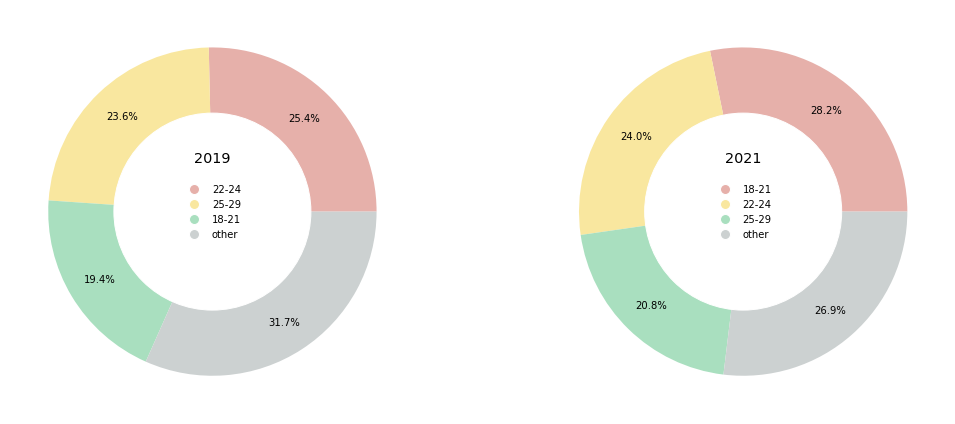

In [138]:
# age
single_ans_chart(['Q1','Q1'],[newbies2019,newbies2021]);

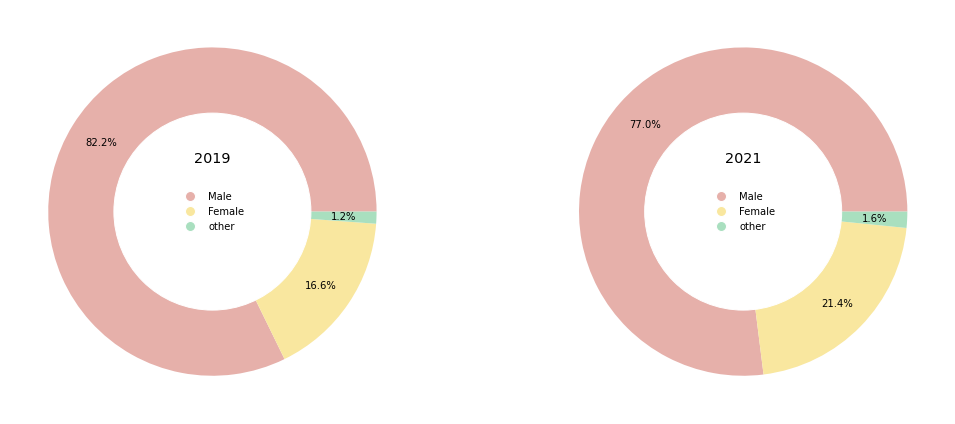

In [139]:
# gender
single_ans_chart(['Q2','Q2'],[newbies2019,newbies2021], num=2);

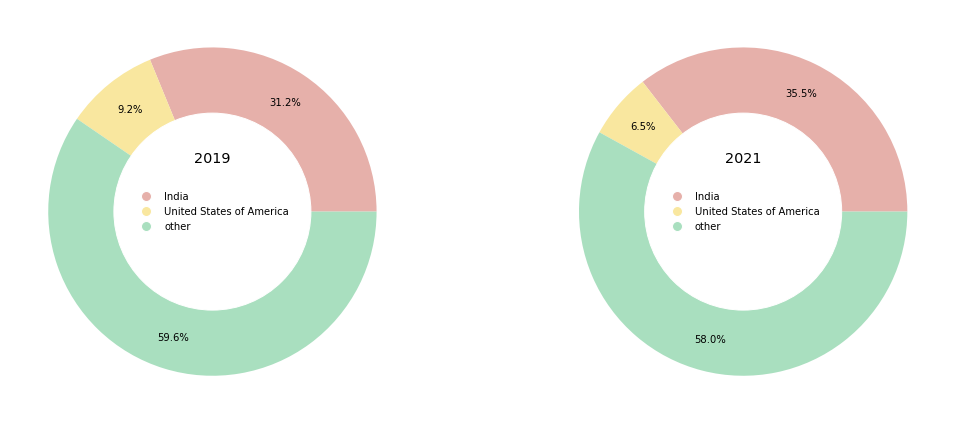

In [140]:
# country of residence
single_ans_chart(['Q3','Q3'],[newbies2019,newbies2021],num=2);

Education and work is made of several questions.

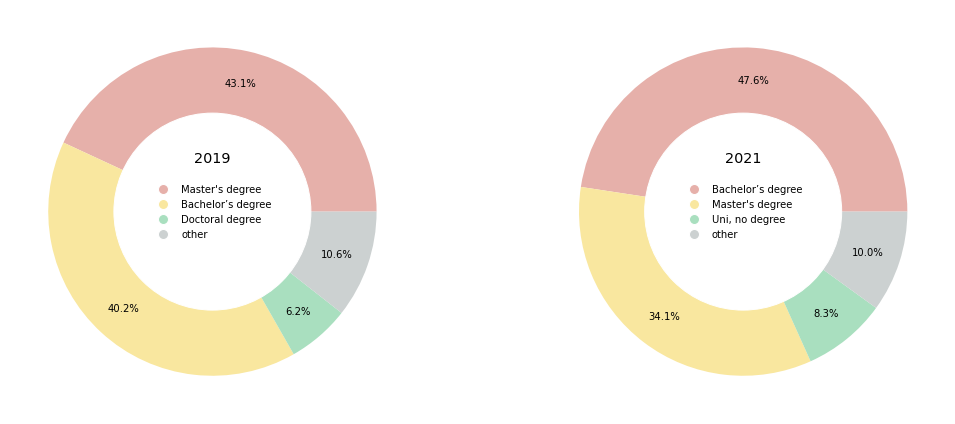

In [141]:
# highest formal education
single_ans_chart(['Q4','Q4'],[newbies2019,newbies2021]);

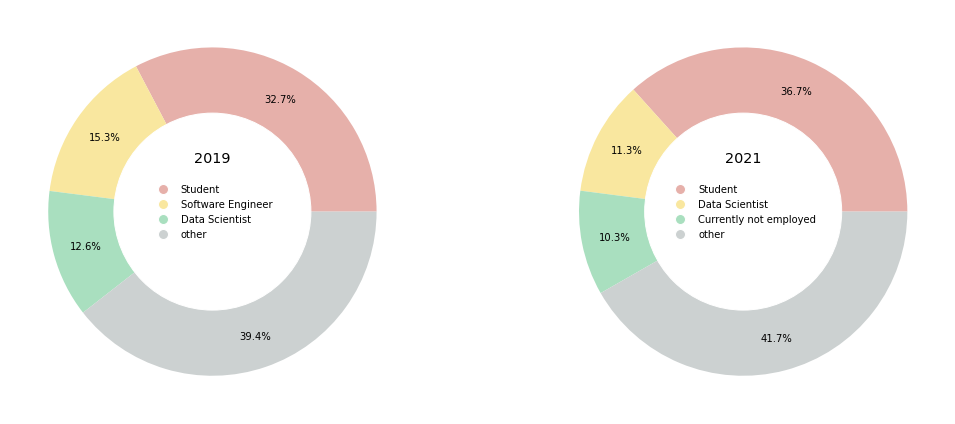

In [142]:
# current job
single_ans_chart(['Q5','Q5'],[newbies2019,newbies2021]);

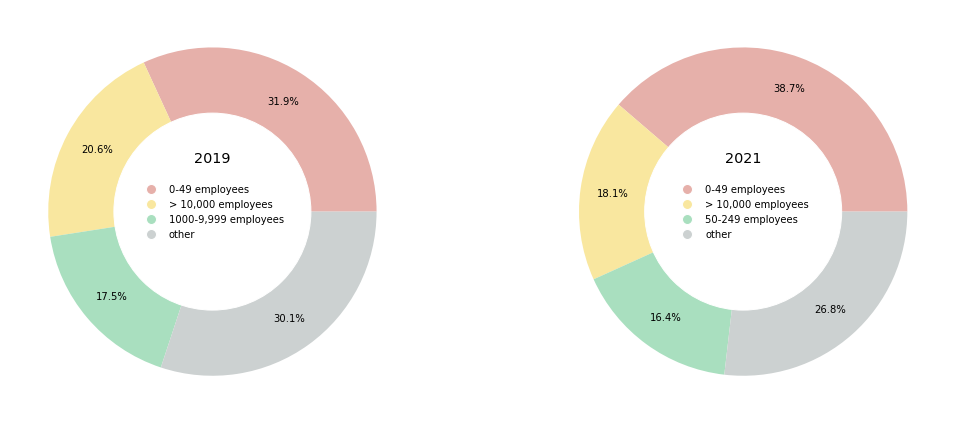

In [143]:
# size of a company employer
single_ans_chart(['Q6','Q21'],[newbies2019,newbies2021]);

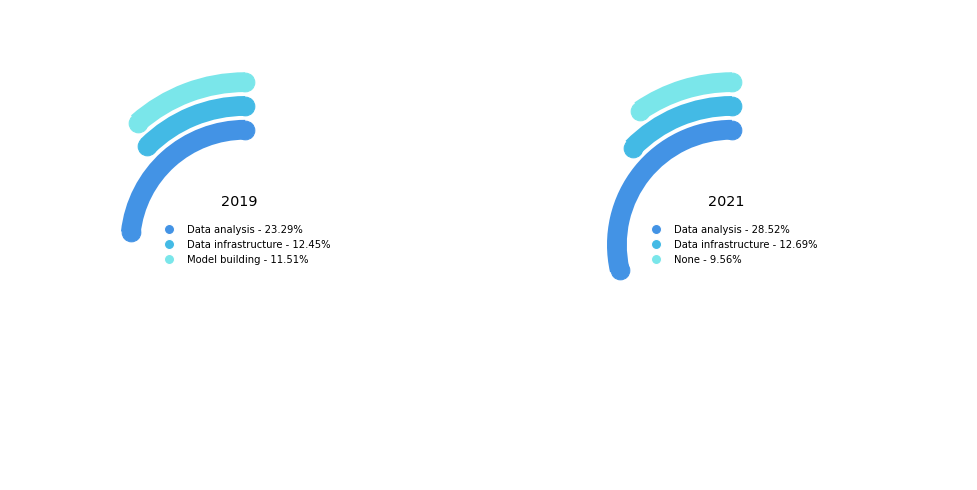

In [144]:
# activities that make up a role at work
multi_ans_charts(['Q9','Q24'],[newbies2019,newbies2021]);

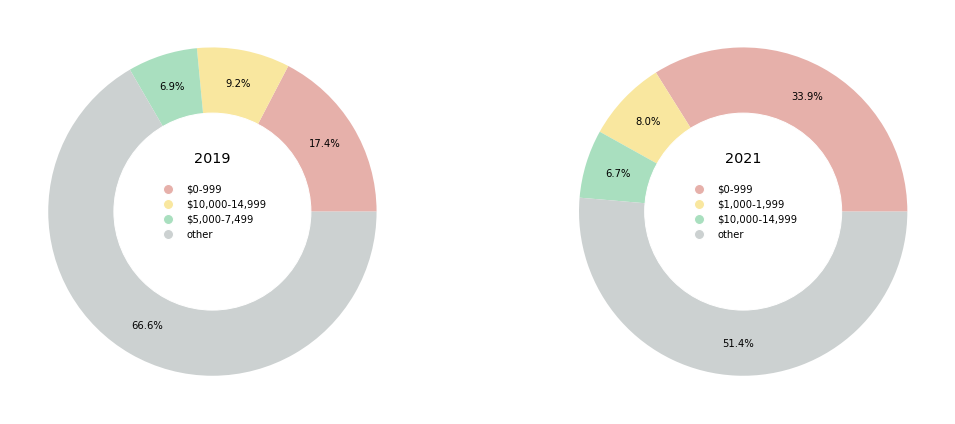

In [145]:
# current salary
single_ans_chart(['Q10','Q25'],[newbies2019,newbies2021]);

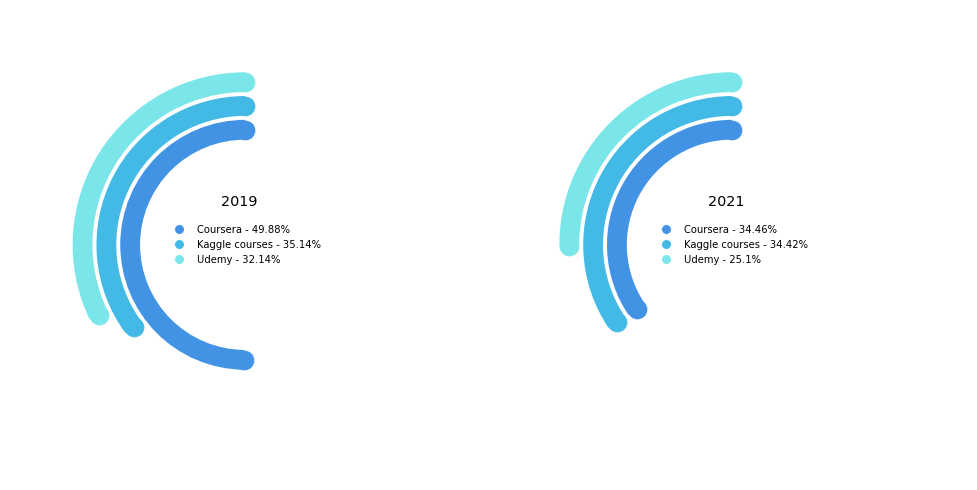

In [88]:
# online courses platforms
multi_ans_charts(['Q13','Q40'],[newbies2019,newbies2021]);

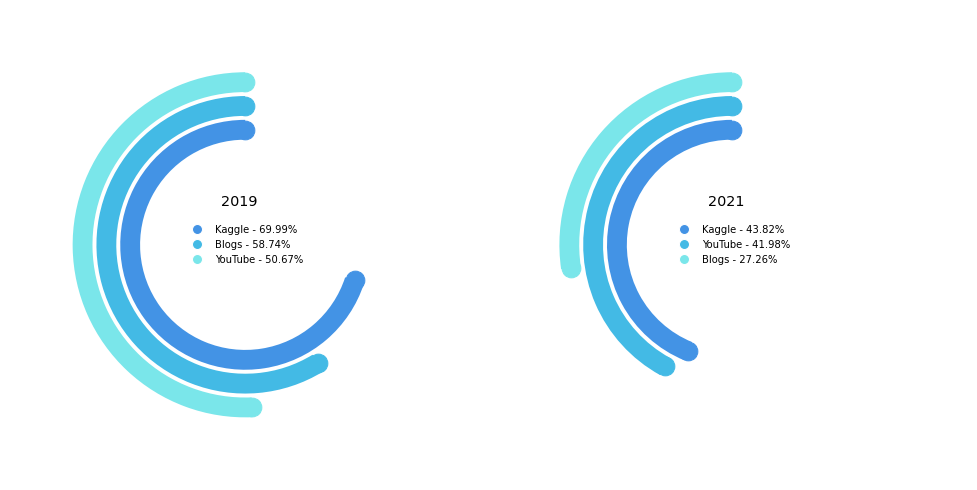

In [151]:
# social media
multi_ans_charts(['Q12','Q42'],[newbies2019,newbies2021]);

Technologies consists of different questions.

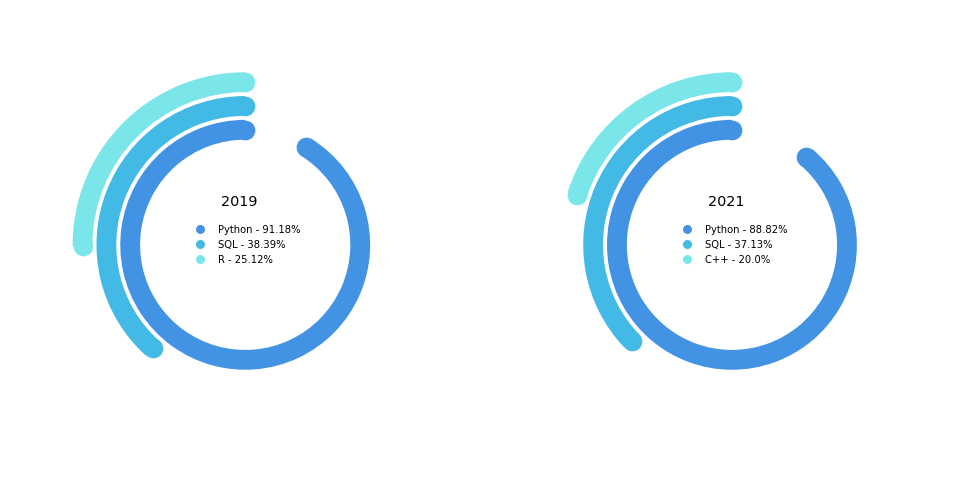

In [146]:
# most frequently used programming language
multi_ans_charts(['Q18','Q7'],[newbies2019,newbies2021]);

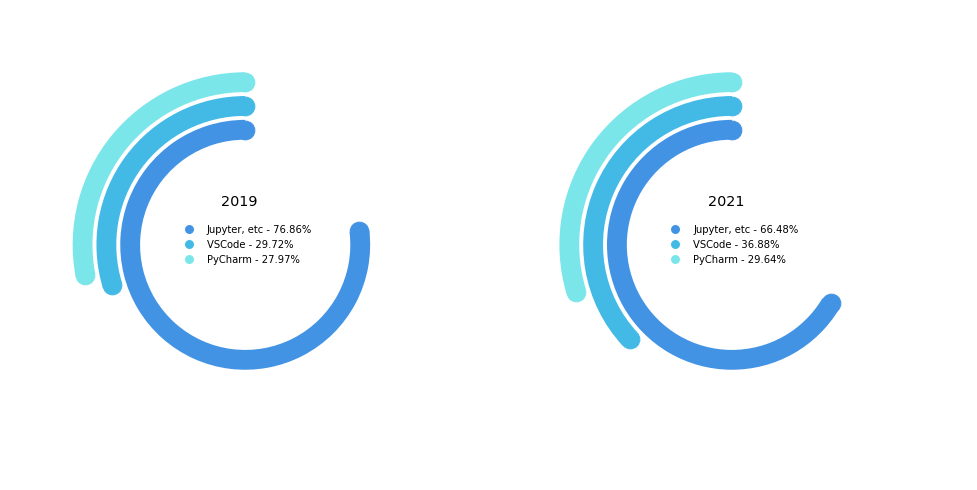

In [147]:
# ide used
multi_ans_charts(['Q16','Q9'],[newbies2019,newbies2021]);

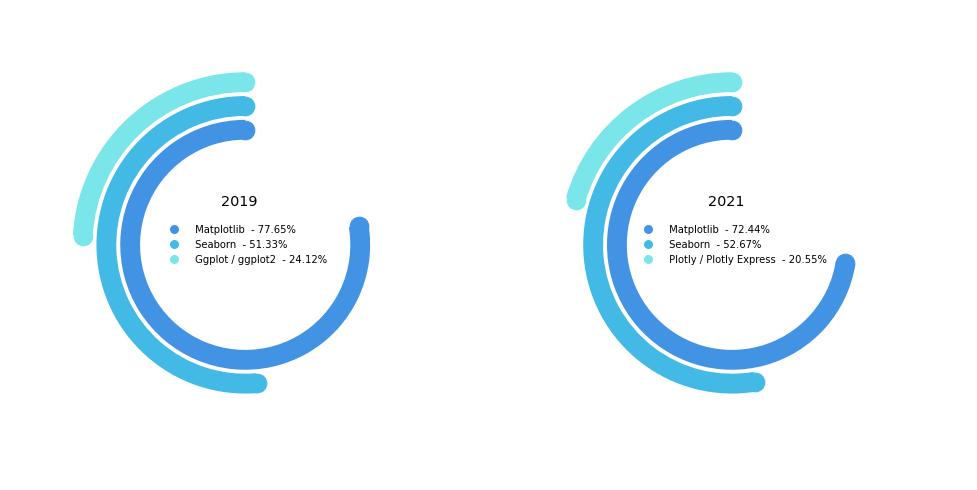

In [148]:
# data viz libraries
multi_ans_charts(['Q20','Q14'],[newbies2019,newbies2021]);

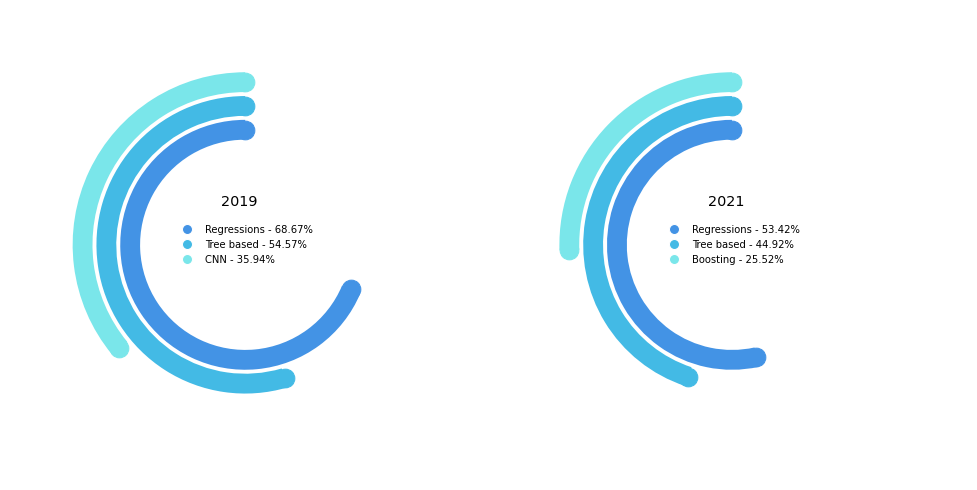

In [149]:
# ml algorithms
multi_ans_charts(['Q24','Q17'],[newbies2019,newbies2021]);

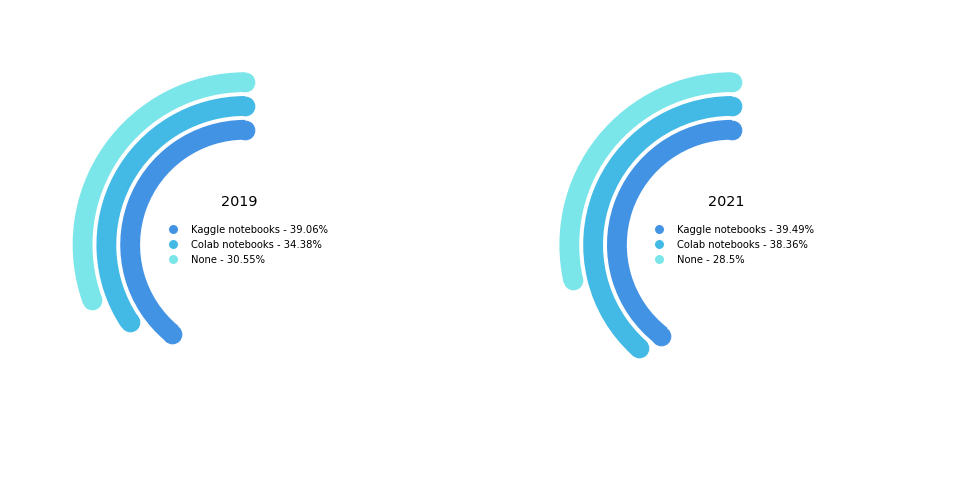

In [150]:
# hosted notebooks
multi_ans_charts(['Q17','Q10'],[newbies2019,newbies2021]);

Now, since I live in Russia I'd like to see how Kaggle users from changed.

In [160]:
russia2019 = s2019[s2019['Q3']=='Russia']
russia2021 = s2021[s2021['Q3']=='Russia']

russia2019,russia2021 = process(russia2019,russia2021)

In [161]:
len(russia2019),len(russia2021)

(626, 742)

About 20% more Russian Kaggle users in 2021.

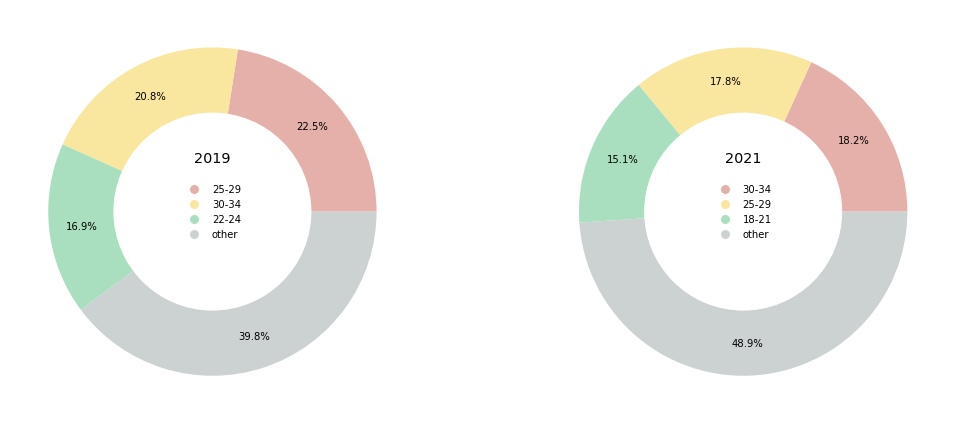

In [162]:
# age
single_ans_chart(['Q1','Q1'],[russia2019,russia2021]);

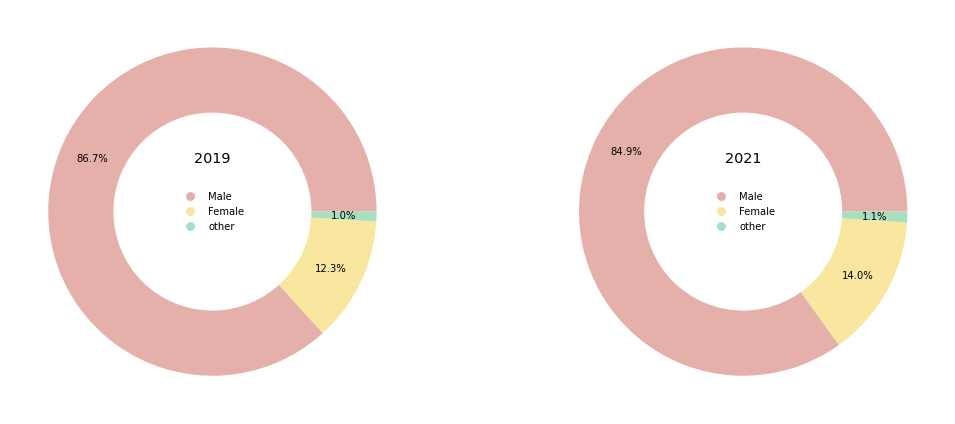

In [163]:
# gender
single_ans_chart(['Q2','Q2'],[russia2019,russia2021],num=2);

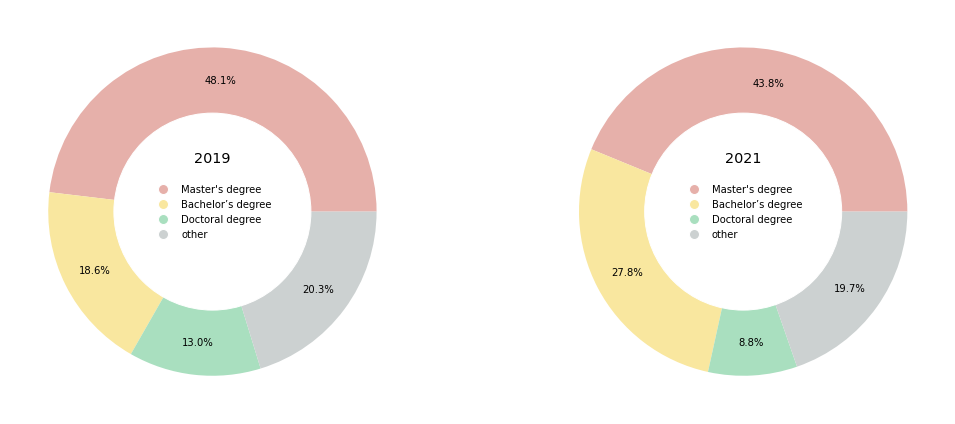

In [164]:
# highest formal education
single_ans_chart(['Q4','Q4'],[russia2019,russia2021]);

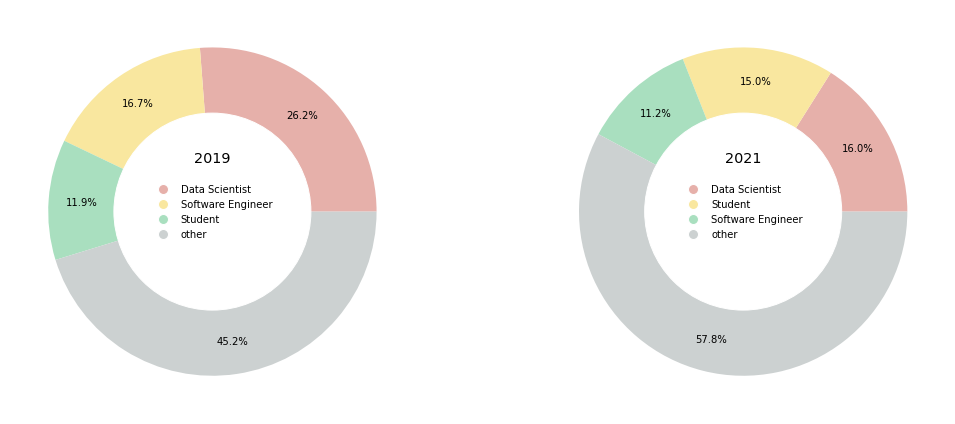

In [165]:
# current job
single_ans_chart(['Q5','Q5'],[russia2019,russia2021]);

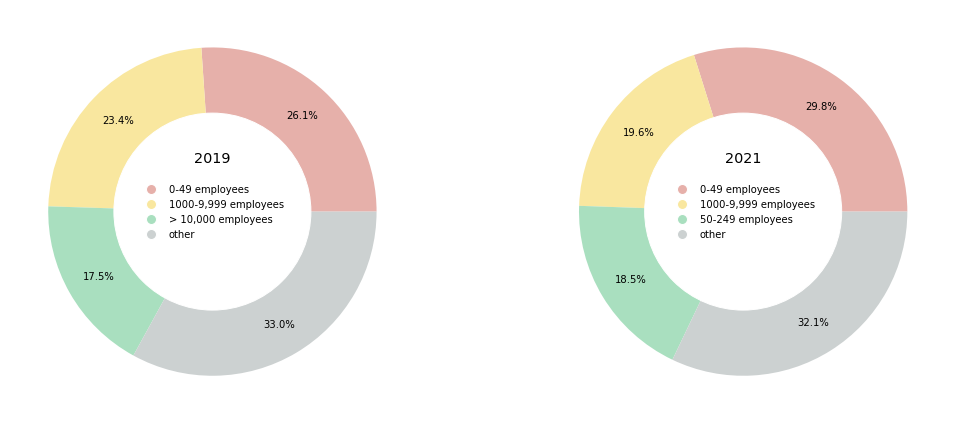

In [166]:
# size of a company employer
single_ans_chart(['Q6','Q21'],[russia2019,russia2021]);

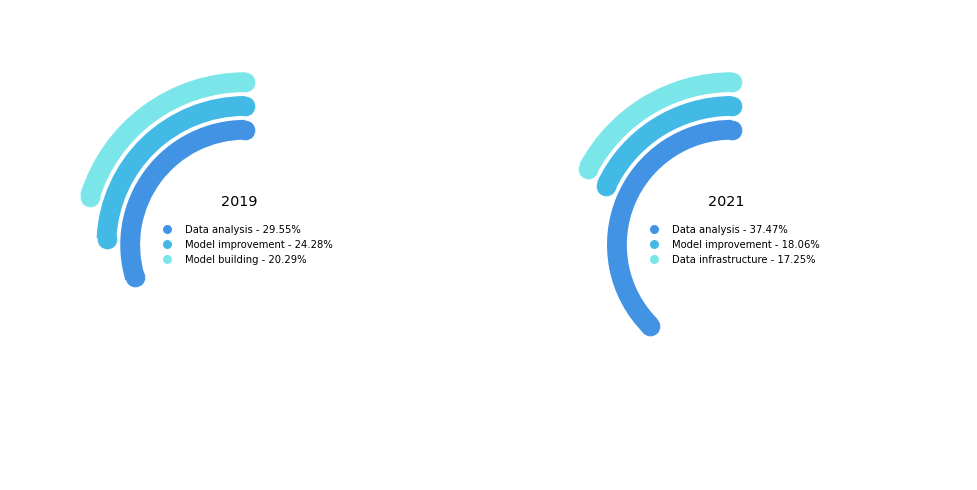

In [168]:
# activities that make up a role at work
multi_ans_charts(['Q9','Q24'],[russia2019,russia2021]);

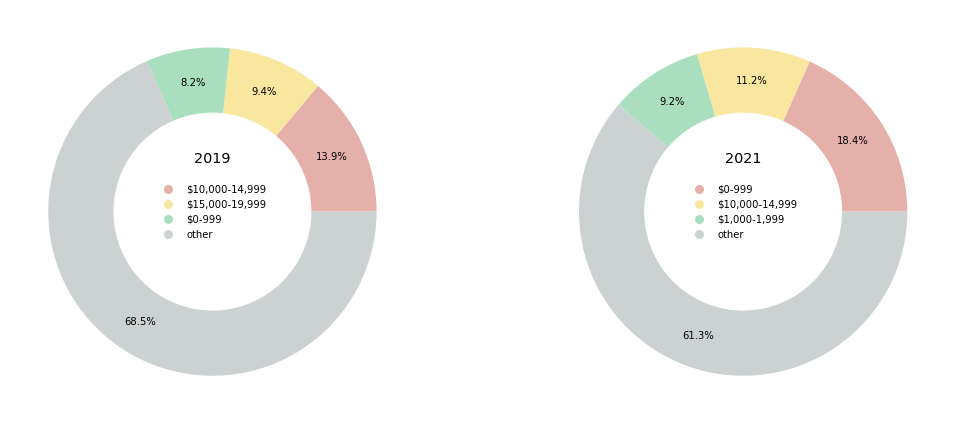

In [169]:
# current salary
single_ans_chart(['Q10','Q25'],[russia2019,russia2021]);

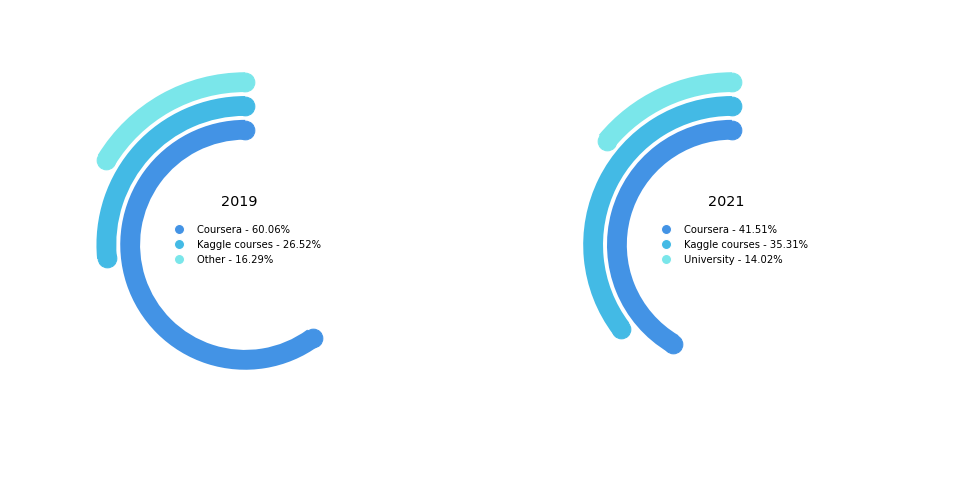

In [170]:
# online platforms
multi_ans_charts(['Q13','Q40'],[russia2019,russia2021]);

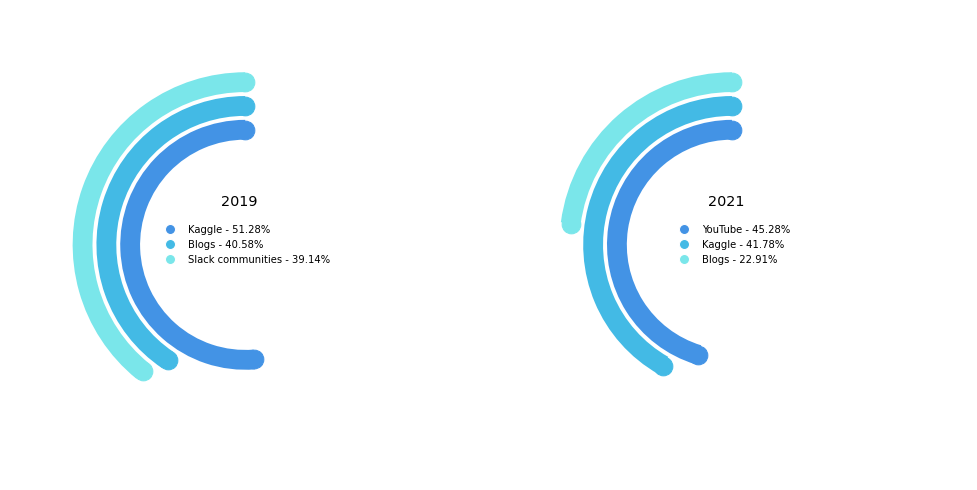

In [171]:
# social media
multi_ans_charts(['Q12','Q42'],[russia2019,russia2021]);

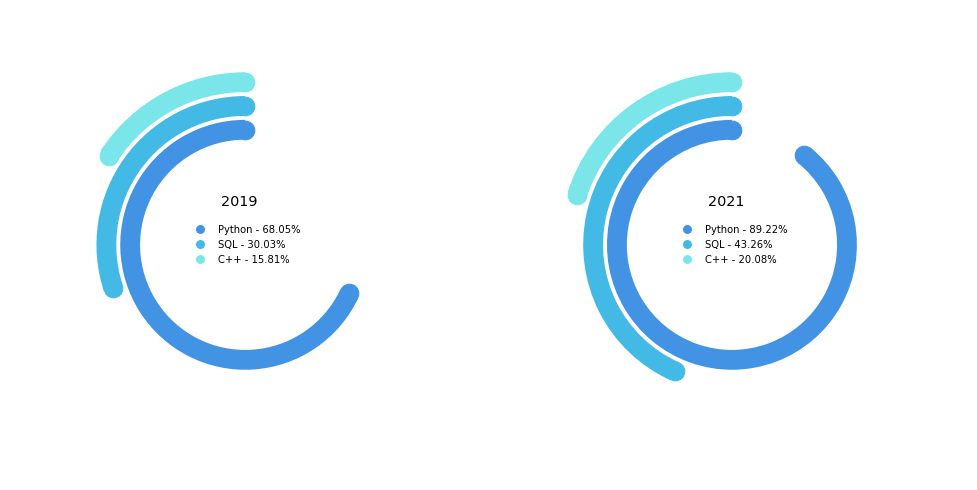

In [172]:
# programming languages
multi_ans_charts(['Q18','Q7'],[russia2019,russia2021]);

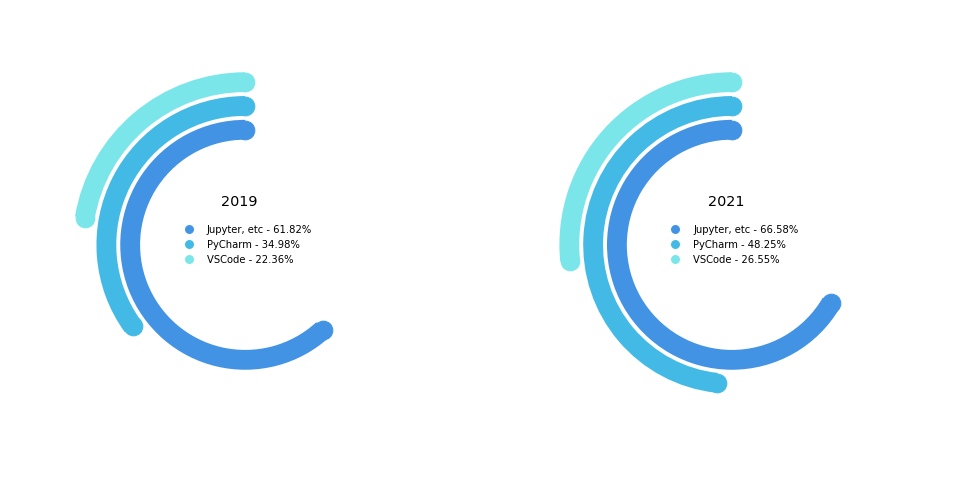

In [173]:
# ide
multi_ans_charts(['Q16','Q9'],[russia2019,russia2021]);

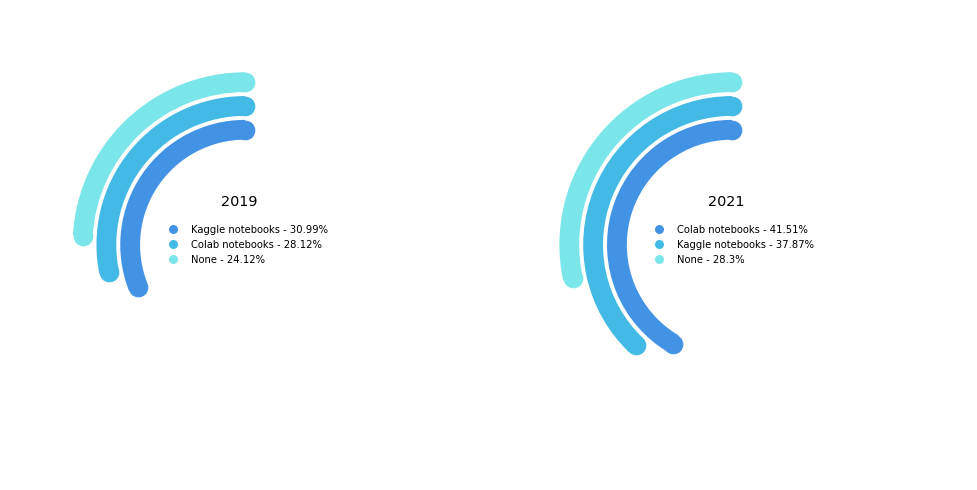

In [174]:
# hosted notebooks
multi_ans_charts(['Q17','Q10'],[russia2019,russia2021]);

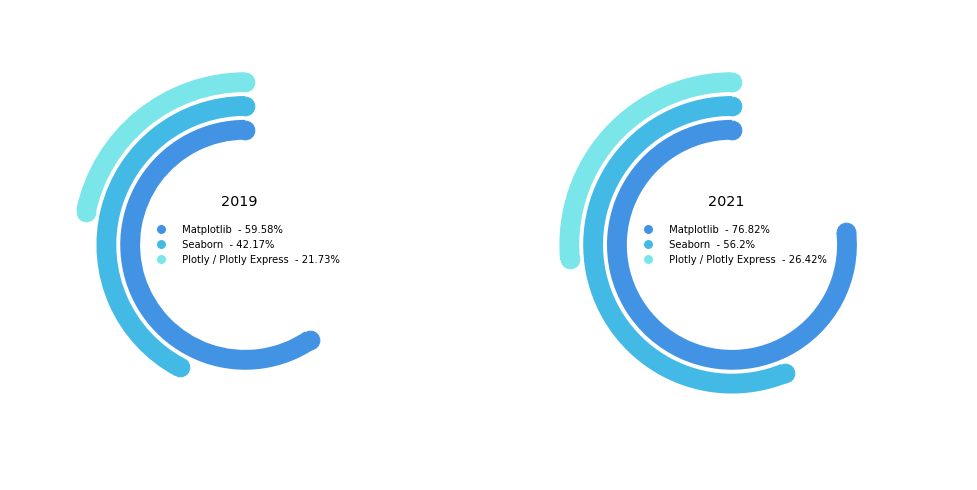

In [175]:
# data viz libraries
multi_ans_charts(['Q20','Q14'],[russia2019,russia2021]);

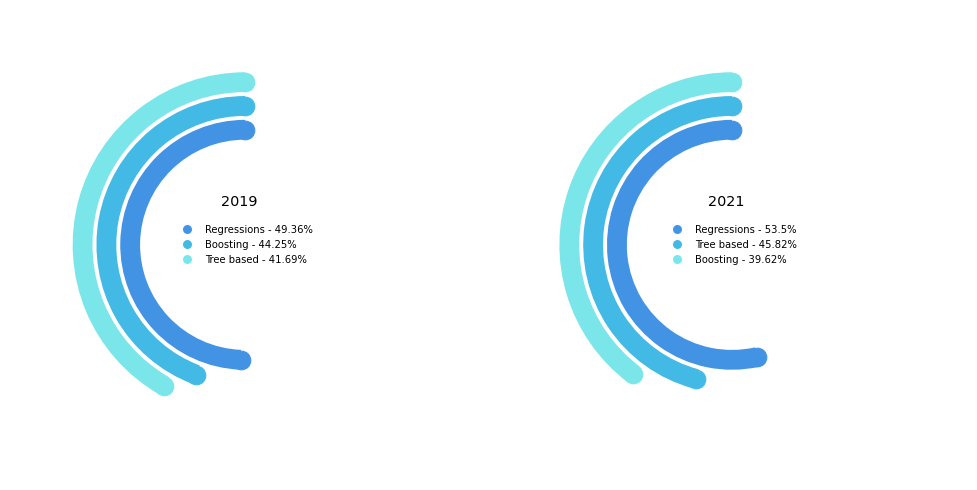

In [176]:
# algos
multi_ans_charts(['Q24','Q17'],[russia2019,russia2021]);